## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import requests
import zipfile

url = 'https://drive.upm.es/s/2DDPE2zHw5dbM3G/download'
zip_name = 'dataset.zip'

r = requests.get(url, stream=True)
with open(zip_name, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        f.write(chunk)

if os.path.getsize(zip_name) < 10000:
    print(f"ERREUR : Le fichier {zip_name} est trop petit. Le lien est invalide ou nécessite une connexion.")
else:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(".")

    target_file = 'xview_ann_train.json'
    found_path = None

    for root, dirs, files in os.walk("."):
        if target_file in files:
            found_path = os.path.join(root, target_file)
            break

    if found_path:
        print(f"SUCCÈS : Fichier trouvé à : {found_path}")

        import json
        json_file = found_path

        with open(json_file) as ifs:
            json_data = json.load(ifs)
        print("Base de données chargée avec succès !")

    else:
        print(f"ERREUR : {target_file} reste introuvable après extraction.")

SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !


In [2]:
import tensorflow as tf

# Vérifie la présence de processeurs graphiques
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Configuration pour ne pas allouer toute la mémoire d'un coup
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU activé : {len(gpus)} processeur(s) détecté(s)")
    except RuntimeError as e:
        print(e)
else:
    print("GPU non détecté. Activez l'accélérateur dans les réglages du notebook.")

2026-02-23 07:38:43.450362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771832323.639142      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771832323.695115      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771832324.133086      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771832324.133134      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771832324.133137      24 computation_placer.cc:177] computation placer alr

GPU activé : 1 processeur(s) détecté(s)


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
!pip install rasterio

In [6]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)
labels = [img.objects[0].category for img in anns]

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.15, random_state=42, shuffle=True, stratify=labels)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 15934
Number of validation images: 2812


In [10]:
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, Flatten, Input, Add
from tensorflow.keras.models import Model
import tensorflow as tf

def dense_residual_block(x, units, dropout_rate=0.15):
    shortcut = Dense(units, use_bias=False)(x)
    shortcut = BatchNormalization()(shortcut)

    out = Dense(units, use_bias=False)(x)
    out = BatchNormalization()(out)
    out = Activation('swish')(out)
    out = Dropout(dropout_rate)(out)
    out = Dense(units, use_bias=False)(out)
    out = BatchNormalization()(out)

    out = Add()([out, shortcut])
    out = Activation('swish')(out)
    return out

inputs = Input(shape=(96, 96, 3))
x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
x = tf.keras.layers.RandomRotation(0.25)(x)
x = Flatten()(x)  # 27648

x = Dense(512, use_bias=False)(x)   # 27648×512 = 14.2M
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.15)(x)

# Blocs résiduels dans l'espace compressé
x = dense_residual_block(x, 512, dropout_rate=0.15)  # 512×512×3 = 0.79M
x = dense_residual_block(x, 256, dropout_rate=0.15)  # 512×256+256×256 = 0.2M

outputs = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

I0000 00:00:1771832354.822936      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 96, 96, 3) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 27648)     │          0 │ random_rotation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 14,155,776 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,144 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,144 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,144 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512)       │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,072 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,284,493 (58.31 MB)

 Trainable params: 15,278,861 (58.28 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [11]:
#from tensorflow.keras.optimizers import Adam
#
## Learning rate is changed to 0.001
#opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

terminate = TerminateOnNaN()

callbacks = [model_checkpoint, early_stop, terminate]

In [13]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        working = list(objs)
        if do_shuffle:
            np.random.shuffle(working)
        groups = [working[i:i+batch_size] for i in range(0, len(working), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                img = load_geoimage(filename)
                img = img.astype(np.float32)
                if img.ndim == 4:
                    img = img.squeeze(0)
                img_max = img.max()
                if img_max > 1.0:
                    img = img / 255.0 if img_max <= 255.0 else img / 65535.0

                crop_tensor = tf.convert_to_tensor(img)
                img_resized = tf.image.resize(crop_tensor, [96, 96], method='lanczos3')
                images.append(img_resized.numpy())

                label_idx = list(categories.keys())[list(categories.values()).index(obj.category)]
                one_hot = tf.keras.utils.to_categorical(label_idx, num_classes=len(categories))
                labels.append(one_hot)

            yield np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

In [14]:
import math
batch_size = 128
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

steps_per_epoch = math.ceil(len(objs_train) / batch_size)
valid_steps = math.ceil(len(objs_valid) / batch_size)

In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# labels_train = liste des catégories pour chaque objet dans objs_train
labels_train = [obj.category for (_, obj) in objs_train]
classes = np.array(sorted(set(labels_train)))

weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_train)
class_weight_dict = dict(zip(classes, weights))

In [16]:
# Generators
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers import Nadam

#counts_array = np.array([counts[categories[i]] for i in range(len(categories))], dtype=np.float32)
#alpha_per_class = 1.0 / np.sqrt(counts_array)
#alpha_per_class = alpha_per_class / alpha_per_class.sum()

lr_schedule = CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=100 * steps_per_epoch
)
optimizer = Nadam(learning_rate=lr_schedule, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss=CategoricalFocalCrossentropy(gamma=0.5),
    metrics=['accuracy']
)

In [18]:
import math
import numpy as np

print('Training model')

h = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1) + ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 878ms/step - accuracy: 0.2287 - loss: 0.5591 - val_accuracy: 0.2600 - val_loss: 0.5138
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 861ms/step - accuracy: 0.3450 - loss: 0.4297 - val_accuracy: 0.3350 - val_loss: 0.4705
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 847ms/step - accuracy: 0.3935 - loss: 0.4031 - val_accuracy: 0.2674 - val_loss: 0.5146
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 853ms/step - accuracy: 0.4139 - loss: 0.3882 - val_accuracy: 0.2994 - val_loss: 0.4907
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 829ms/step - accuracy: 0.4287 - loss: 0.3788 - val_accuracy: 0.3538 - val_loss: 0.4359
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 800ms/step - accuracy: 0.4405 - loss: 0.3694 - val_accuracy: 0.3698 - val_loss: 0.4158
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 790ms/step - accuracy: 0.4583 - loss: 0.3538 - val_accuracy: 0.3503 - val_loss: 0.4506
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 809ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 737ms/step - accuracy: 0.7438 - loss: 0.1529 - val_accuracy: 0.5977 - val_loss: 0.2729
Epoch 74/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 737ms/step - accuracy: 0.7521 - loss: 0.1485 - val_accuracy: 0.5977 - val_loss: 0.2567
Epoch 75/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 741ms/step - accuracy: 0.7527 - loss: 0.1498 - val_accuracy: 0.6016 - val_loss: 0.2704
Epoch 76/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 740ms/step - accuracy: 0.7480 - loss: 0.1485 - val_accuracy: 0.6016 - val_loss: 0.2624
Epoch 77/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 737ms/step - accuracy: 0.7575 - loss: 0.1471 - val_accuracy: 0.6055 - val_loss: 0.2622
Epoch 78/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7561 - loss: 0.1446

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 754ms/step - accuracy: 0.7560 - loss: 0.1446 - val_accuracy: 0.6367 - val_loss: 0.2577
Epoch 79/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 753ms/step - accuracy: 0.7597 - loss: 0.1417 - val_accuracy: 0.6250 - val_loss: 0.2555
Epoch 80/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 739ms/step - accuracy: 0.7636 - loss: 0.1416 - val_accuracy: 0.6133 - val_loss: 0.2532
Epoch 81/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 735ms/step - accuracy: 0.7676 - loss: 0.1408 - val_accuracy: 0.6172 - val_loss: 0.2552
Epoch 82/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.7717 - loss: 0.1376

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 750ms/step - accuracy: 0.7717 - loss: 0.1377 - val_accuracy: 0.6445 - val_loss: 0.2578
Epoch 83/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 735ms/step - accuracy: 0.7707 - loss: 0.1375 - val_accuracy: 0.6367 - val_loss: 0.2550
Epoch 84/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 733ms/step - accuracy: 0.7711 - loss: 0.1351 - val_accuracy: 0.6289 - val_loss: 0.2509
Epoch 85/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 731ms/step - accuracy: 0.7759 - loss: 0.1347 - val_accuracy: 0.6211 - val_loss: 0.2511
Epoch 86/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 733ms/step - accuracy: 0.7750 - loss: 0.1368 - val_accuracy: 0.6211 - val_loss: 0.2528
Epoch 87/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 729ms/step - accuracy: 0.7710 - loss: 0.1371 - val_accuracy: 0.6328 - val_loss: 0.2489
Epoch 88/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 728ms/step - accuracy: 0.7776 - loss: 0.1330 - val_accuracy: 0.6250 - val_loss: 0.2535
Epoch 89/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 730ms/step - accuracy: 0.7758 - loss: 0.1357 - val_accuracy: 0.6094 - val_loss: 0.2531
Epoch 90/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 738ms/step - accuracy: 0.7713 - loss: 0.1362 - val_accuracy: 0.6094 - val_loss: 0.2522
Epoch 91/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 739ms/step - accuracy: 0.7729 - loss: 0.1342 - val_accuracy: 0.6133 - val_loss: 0.2556
Epoch 92/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 746ms/step - accuracy: 0.7785 - loss: 0.1336 - val_accuracy: 0.6094 - val_loss: 0.2550
Epoch 93/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 731ms/step - accuracy: 0.7708 - loss: 0.1335 - val_accuracy: 0.6211 - val_loss: 0.2544
Epoch 94/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 726ms/step - accuracy: 0.7740 - loss: 0.1361 - val_accuracy: 0.6094 - val_loss: 0.2541
Epoch 95/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 729ms/step - accuracy: 0.7794 - loss: 0.1338 - val_accuracy: 0.6055 - val_loss: 0.2539
Epoch 96/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 730ms/step - accuracy: 0.7788 - loss: 0.1319 - val_accuracy: 0.6133 - val_loss: 0.2536
Epoch 97/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 731ms/step - accuracy: 0.7761 - loss: 0.1331 - val_accuracy: 0.6172 - val_loss: 0.2539
Epoch 98/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 730ms/step - accuracy: 0.7843 - loss: 0.1292 - val_accuracy: 0.6172 - val_loss: 0.2541
Epoch 99/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 731ms/step - accuracy: 0.7787 - loss: 0.1318 - val_accuracy: 0.6094 - val_loss: 0.2542
Epoch 100/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 729ms/step - accuracy: 0.7888 - loss: 0.1292 - val_accuracy: 0.6094 - val_loss: 0.2546
Best validation model: epoch 82 - val_accuracy 0.64453125


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


#### Validation
Compute validation metrics.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [20]:
import numpy as np
import tensorflow as tf

model.load_weights('model.keras')
y_true, y_pred = [], []
all_images = []
temp_true_labels = []

for ann in anns_valid:
    image_raw = load_geoimage(ann.filename)
    img = image_raw.astype(np.float32)
    if img.ndim == 4:
        img = img.squeeze(0)
    img_max = img.max()
    if img_max > 1.0:
        img = img / 255.0 if img_max <= 255.0 else img / 65535.0

    img_resized = tf.image.resize(tf.convert_to_tensor(img), [96, 96], method='lanczos3')

    for obj_pred in ann.objects:
        all_images.append(img_resized.numpy())
        temp_true_labels.append(obj_pred.category)

if all_images:
    X_valid = np.array(all_images)
    print(f"Lancement de la prédiction sur {len(X_valid)} objets...")
    all_predictions = model.predict(X_valid, batch_size=64, verbose=1)
    category_names = list(categories.values())
    for i in range(len(all_predictions)):
        pred_category = category_names[np.argmax(all_predictions[i])]
        y_true.append(temp_true_labels[i])
        y_pred.append(pred_category)

Lancement de la prédiction sur 2812 objets...
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


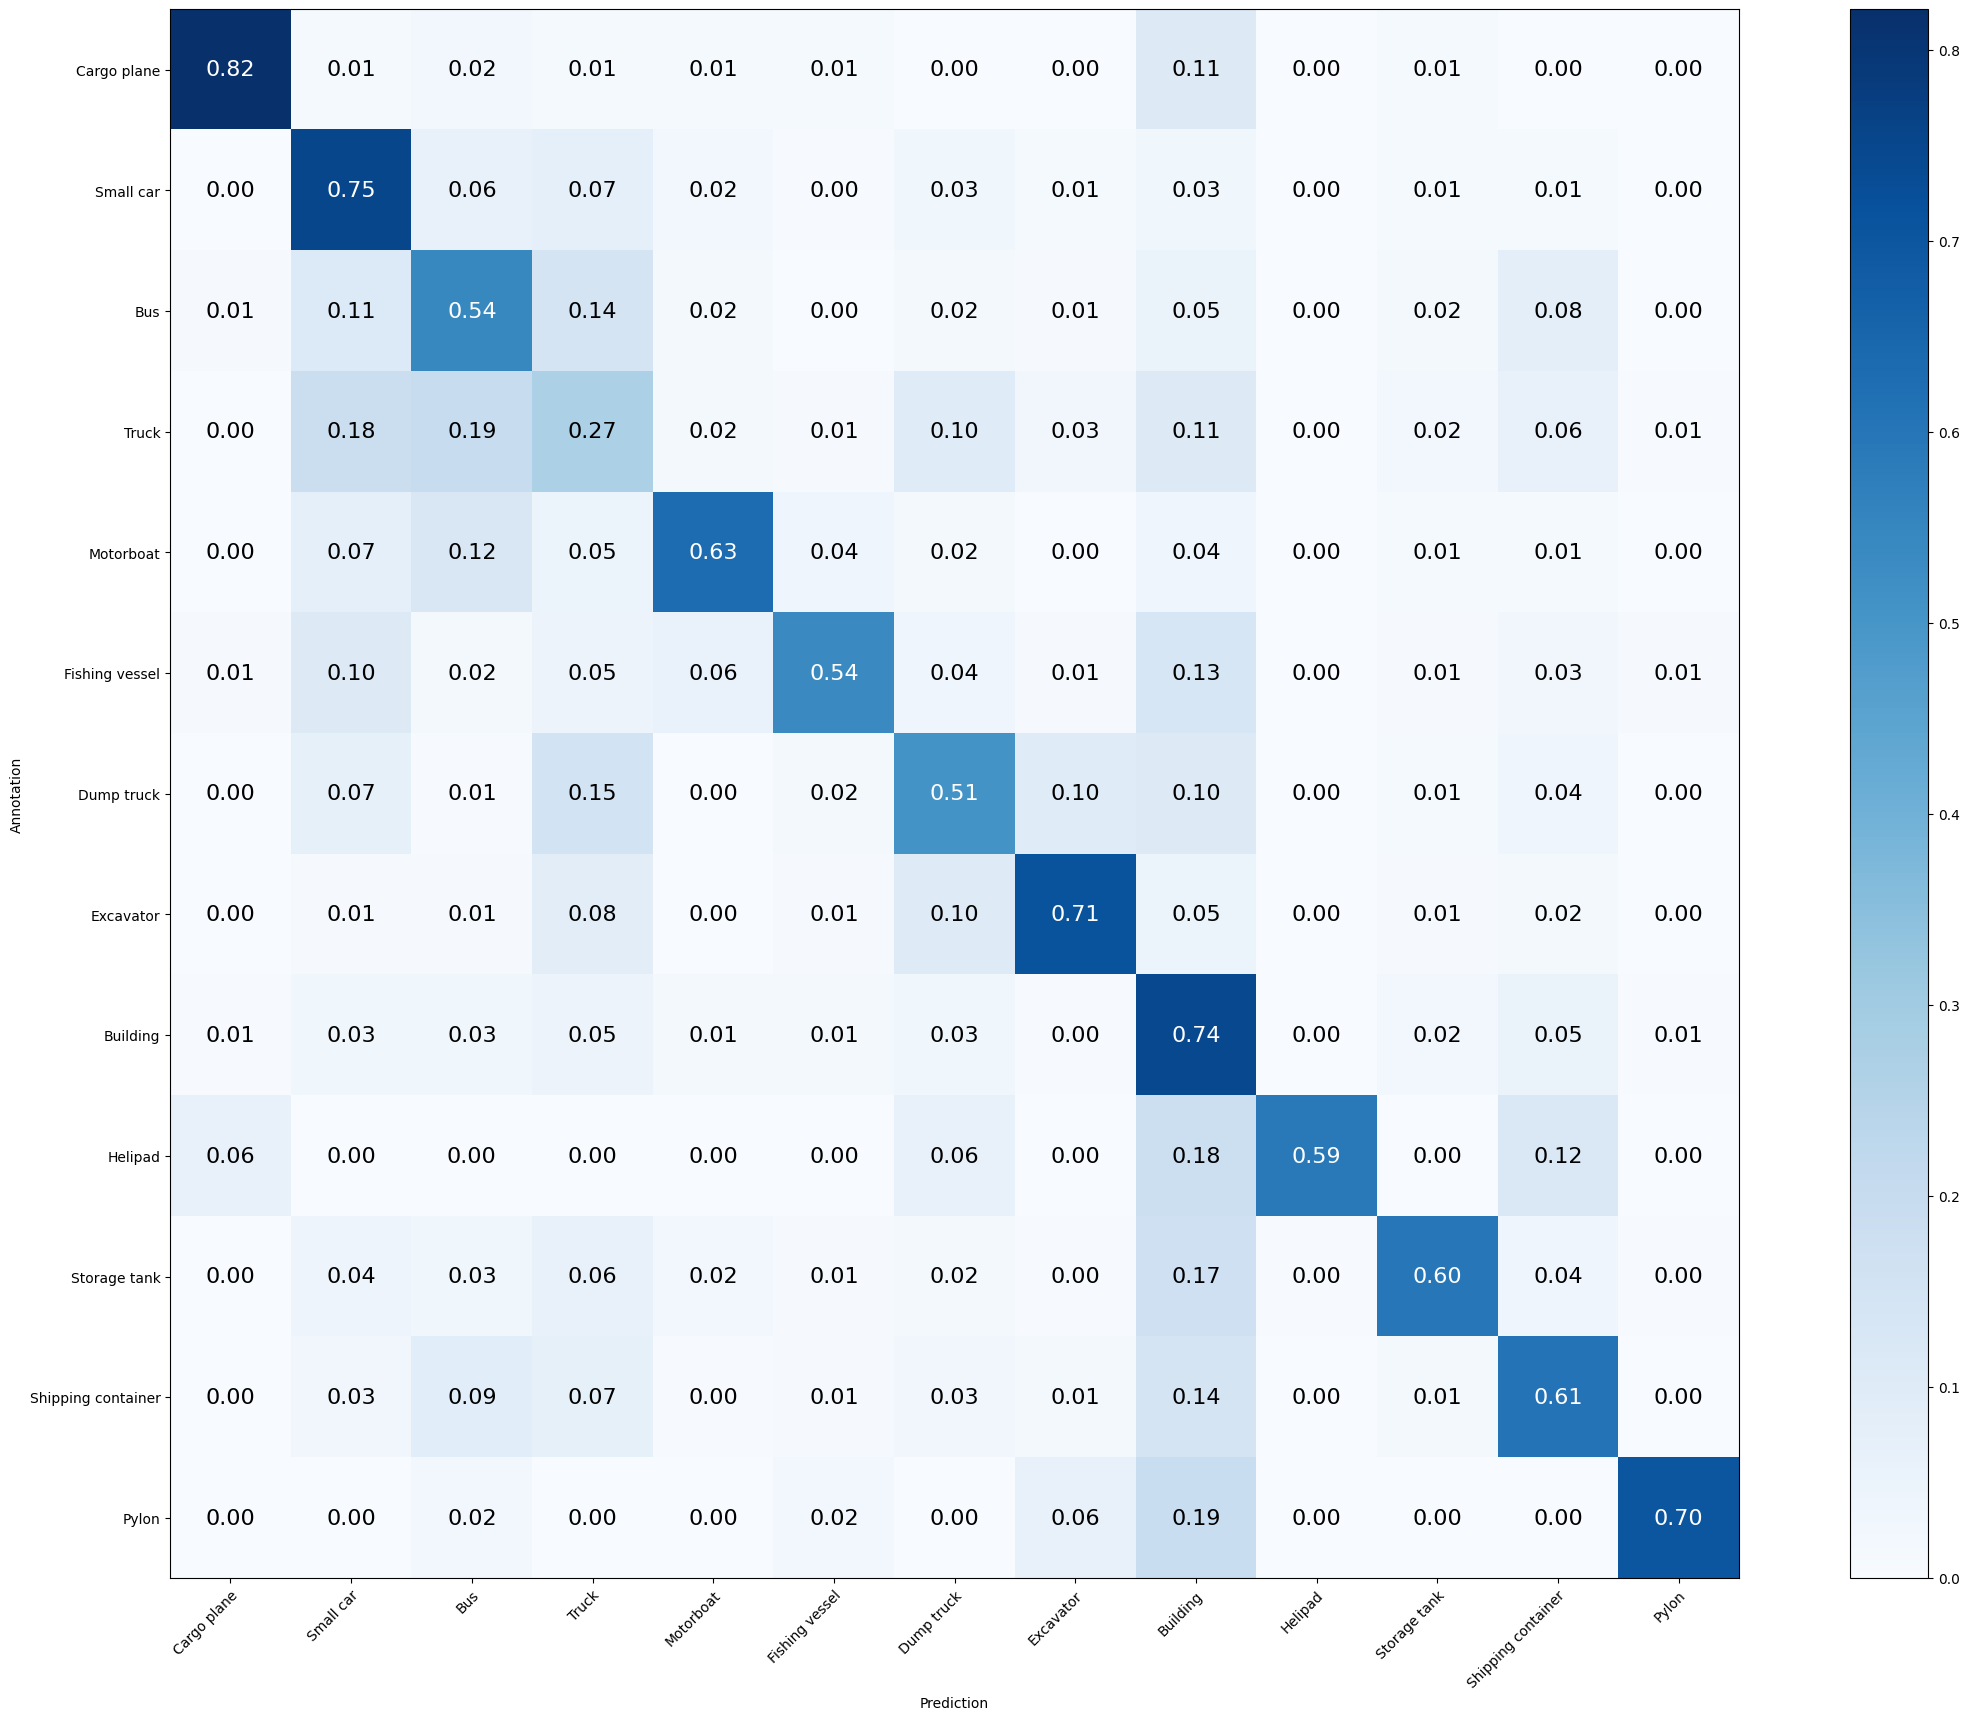

In [21]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [22]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 61.735%
Mean Recall: 61.621%
Mean Precision: 66.741%
> Cargo plane: Recall: 82.105% Precision: 91.765% Specificity: 99.742% Dice: 86.667%
> Small car: Recall: 74.950% Precision: 70.169% Specificity: 93.126% Dice: 72.481%
> Bus: Recall: 54.340% Precision: 46.602% Specificity: 93.522% Dice: 50.174%
> Truck: Recall: 27.108% Precision: 33.333% Specificity: 92.742% Dice: 29.900%
> Motorboat: Recall: 63.125% Precision: 70.139% Specificity: 98.379% Dice: 66.447%
> Fishing vessel: Recall: 53.774% Precision: 67.059% Specificity: 98.965% Dice: 59.686%
> Dump truck: Recall: 50.811% Precision: 48.958% Specificity: 96.270% Dice: 49.867%
> Excavator: Recall: 71.186% Precision: 65.625% Specificity: 98.367% Dice: 68.293%
> Building: Recall: 74.397% Precision: 66.501% Specificity: 91.113% Dice: 70.228%
> Helipad: Recall: 58.824% Precision: 90.909% Specificity: 99.964% Dice: 71.429%
> Storage tank: Recall: 59.545% Precision: 76.163% Specificity: 98.418% Dice: 66.837%
> Shipping container:

#### Testing
Try to improve the results provided in the competition.

In [23]:
import os
import numpy as np

anns = []
root_dir = './xview_recognition/'
test_dir = os.path.join(root_dir, 'xview_test')
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for filename in filenames:
        rel_dir = os.path.relpath(dirpath, root_dir)
        clean_filename = os.path.join(rel_dir, filename)
        image = GenericImage(clean_filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [24]:
import numpy as np
import tensorflow as tf

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
all_test_images = []
metadata = []
ann_id = 0

print("Préparation des images de test...")
for idx, ann in enumerate(anns):
    predictions_data["images"][idx] = {
        "image_id": ann.filename.split('/')[-1],
        "filename": ann.filename,
        "width": int(ann.tile[2]),
        "height": int(ann.tile[3])
    }

    image_raw = load_geoimage(ann.filename)
    img = image_raw.astype(np.float32)
    if img.ndim == 4:
        img = img.squeeze(0)
    img_max = img.max()
    if img_max > 1.0:
        img = img / 255.0 if img_max <= 255.0 else img / 65535.0

    img_resized = tf.image.resize(tf.convert_to_tensor(img), [96, 96], method='lanczos3')
    img_final = img_resized.numpy()

    for obj_pred in ann.objects:
        all_test_images.append(img_final)
        metadata.append({
            "image_id": ann.filename.split('/')[-1],
            "bbox": [int(x) for x in obj_pred.bb]
        })

if all_test_images:
    X_test = np.array(all_test_images)
    print(f"Prédiction en cours sur {len(X_test)} détections...")
    all_preds = model.predict(X_test, batch_size=128, verbose=1)
    category_names = list(categories.values())
    for i, pred in enumerate(all_preds):
        predictions_data["annotations"][ann_id] = {
            "image_id": metadata[i]["image_id"],
            "category_id": category_names[np.argmax(pred)],
            "bbox": metadata[i]["bbox"]
        }
        ann_id += 1
print("Test terminé.")

Préparation des images de test...
Prédiction en cours sur 2365 détections...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test terminé.


In [25]:
import json
with open('prediction.json', 'w') as f:
    json.dump(predictions_data, f)